In [1]:
import numpy as np
import scipy as sci
from scipy import optimize
import matplotlib.pyplot as plt

![A little humor first](slack_humor.png)

Most of what I will be showing is based on [Micahel Zingale's textbook](http://bender.astro.sunysb.edu/hydro_by_example/CompHydroTutorial.pdf). 

First, I just want to convince you that hydro simulations are just *a work of art*. 

Essentially, the hydro codes just solve three Euler equations.

$$\partial_t\rho+\nabla \cdot[\rho \textbf{v}]=0$$
$$\partial_t[\rho\textbf{v}]+\nabla\cdot[\rho\textbf{v}\otimes\textbf{v}+P]=0$$
$$\partial_tE+\nabla\cdot[(E+P)\textbf{v}] = 0$$

where $\rho$ is the gas density, $v$ its velocity and $P$ its pressure. 

Here, $E$ is the specific total energy which is related to the specific internal energy as:

$$
\rho E = \rho e + \frac{1}{2} \rho u^2
$$

and the system is closed by an equation of state:

$$p = p(\rho, e)$$

A common equation of state is a *gamma-law EOS*:

$$ p = \rho e (\gamma - 1)$$

where $\gamma$ is a constant.  For an ideal gas, $\gamma$ is the ratio of specific heats, $c_p / c_v$.

# Finite-Volume Methods

The key point of the method to discritize your fields in the way that your conservation laws hold (mass, momentum, and energy). Consider a uniform discretization of the
domain $[x_L, x_R]$. The discretization will go as follows: 
$$x_i = x_L+(i+1/2)\delta x$$
We will also need the midpoint values:
$$x_{i-1/2} = x_i - \delta x = x_L+i\delta x$$
These values define computational cells or *control volumes*:
$$C_i = [x_{i-1/2},x_{i+1/2})$$
Cell averages are defined as:
$$U^n_i \approx \frac{1}{\delta x}\int_{x_{i-1/2}}^{x_{i+1/2}}U(x,t^n)dx$$

We want to solve the following heat equation:
$$\frac{dT}{dt}-\nabla(k\nabla T) = 0$$
Let's discritize everything! We usually use $n$ for time increments and $ijk$ for spatial increments.
$$\frac{dT}{dt} = \frac{T_c^{n+1}-T_c^n}{\Delta t}$$
Divergence theorem:
$$\int\int_V-\nabla\cdot(k\nabla T)dV=\int_S-(k\nabla T)dS$$
$$\int_S-(k\nabla T)dS = \sum (-(k\nabla T)_i\cdot S_i)$$
$$\frac{T_c^{n+1}-T_c^n}{\Delta t}+\sum (-(k\nabla T)_i\cdot S_i) = 0$$
Let's look at one of the faces. For the face $i$, we can write ($A_i$ is the face area, $n_i$ is the direction of the normal):
$$-(k\nabla T)_i\cdot S_i = -k A_i n_i(\frac{dT}{dx})_i = -k A_i n_i\frac{T_E-T_c}{\delta x}$$
We will call $\frac{-kA_i}{\delta x}$ as $f$ for the flux through that face.
In the end we will have:
$$T_c^{n+1} = T_c^n+\Delta t(f_cT_c - \sum f_iT_i)$$

# Example 1.

In [13]:
def FVdemo(T, imax, jmax, time, delt=0.2, k=1, FaceArea=1, dh=1):
    """
    need:
    Tc, Te, Tw, Tn, Ts 
    FluxC, FluxE, FluxW, FluxN, FluxS;
    
    T is an NxN matrix
    delt is a delta t
    """
    Tb0 = 0
    Tb = 240
    i = 0
    j = 0
    for t in range(0,len(time)-1):
        delt = time[t+1] - time[t]
        for i in range(0,imax):
            for j in range(0,jmax):
                Tc = T[i, j];
                dx = dh;

                if (i == imax - 1): 
                    Te = Tb0; 
                    dx = dx / 2;
                else:
                    Te = T[i + 1, j];
                FluxE = (-k * FaceArea) / dx;

                if (i == 0): 
                    Tw = Tb0; 
                    dx = dx / 2; 
                else:
                    Tw = T[i - 1, j];
                FluxW = (-k * FaceArea) / dx;

                if (j == jmax - 1): 
                    Tn = Tb0; 
                    dx = dx / 2; 
                else:
                    Tn = T[i, j + 1];
                FluxN = (-k * FaceArea) / dx;

                if (j == 0): 
                    Ts = Tb; 
                    dx = dx / 2;
                else:
                    Ts = T[i, j - 1];
                FluxS = (-k * FaceArea) / dx;

                FluxC = FluxE + FluxW + FluxN + FluxS;


                T[i, j] = Tc + delt * (FluxC * Tc - (FluxE * Te + FluxW * Tw + FluxN * Tn + FluxS * Ts));
    return T


In [14]:
N = 16
T = np.zeros((N,N))

In [15]:
Tnew = FVdemo(T,N,N,np.linspace(0,10))

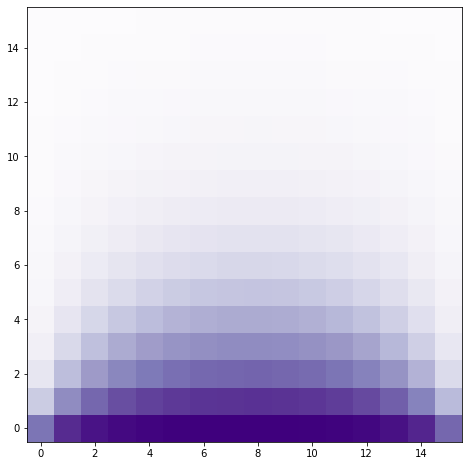

In [16]:
plt.figure(figsize=(20,8))
plt.imshow(Tnew.T,cmap='Purples',origin='lower')

# Core-accretion

Here, we will solve the easy 1D problem for core-accretion. When the self-gravitating gas falls into the planetary core creating its envelope, it creates shocks -- unstable problem! 

We consider a solid planetary core embedded in a circumstellar disk and massive enough to capture its own atmosphere. If $m_c$ is the mass of the core and $c_s$ is the isothermal sound speed of the gas, then the Bondi radius $r_B\equiv Gm_c/c_s^2$ is larger than the radius $r_c$ of the core.

We consider isothermal envelopes in most of this work, having a pressure 
$$P=\rho c_s^2$$
with a single sound speed (temperature) in the entire flow.

Given the core mass $m_c$, the potential of the core depends on the radius $r$ as 
$$\Phi_c(r)=-\frac{Gm_c}{r}$$

The potential of the gas satisfies Poisson’s equation
$$\Delta\Phi_g=4\pi G\rho'(r)$$
in which the source term $\rho'$ is the density deviation from its background value $\rho_\infty$. With this source term, an envelope of constant density $\rho_\infty$ remains gravitationally stable regardless of its size.

The mass of gas becomes
$$M_g(r)=\int 4\pi r^2[\rho(r)-\rho_\infty]dr$$

Therefore, we need to solve the system of equations
$$-c_s^2\partial_r\rho-\rho\partial_r\Phi_c-\rho\frac{M_g}{r^2}=0 $$
$$\partial_r M_g=4\pi G\rho(r)r^2  $$

The momentum euation simply becomes
$$\partial_t[\rho\textbf{v}]+\nabla\cdot[\rho\textbf{v}\otimes\textbf{v}+P]=-\rho\nabla\Phi$$

In [17]:
#----------------Parameters------------------#
r_B = 2.5 # Bondi radius
cs = 1.0
alpha = 1.0
L = 16.
r_c = 1.0
G = 1.0
a=1.0
nx = 128
rho_0 = 1e-8

In [18]:
def self_grav(v):
    """this function is the residual for our solver"""
    
    lnrho = v[0:nx]
    Mg = v[nx:2*nx]
    phi = Phi(r) #gravitational potential
    eq1 = np.dot(D,Mg)-4*np.pi*(r**2)*(np.exp(lnrho)-rho_0)
    eq2 = -(cs**2)*np.dot(D,lnrho)-np.dot(D,phi)-Mg/(r**2)
    eq = np.append(eq2,eq1)
    eq = np.append(eq,lnrho[0]-np.log(rho_0)) # the initial condition
    eq = np.append(eq,Mg[-1])
    

    return eq

def Phi(r):
    return -r_B/r

def guess(x):
    """this is the solution in hydrostatic equilibrium"""
    return np.log(rho_0*np.exp(r_B/x-r_B/L))

def GenerateMatrixFD(n,order,h): 
    """
    orders: 0 = (f(x+h)-f(x))/h
    1 = (f(x) - f(x-h))/h
    2 = (f(x+h) - f(x-h))/2h
    """
    a=np.zeros((n,n),int)
    if order==0:
        for i in range (n):
            for j in range(i,n):
                m = n-j
                m1 = n-j-1
                a[i,-m]=-1
                a[i,-m1]=1
                break
        a[-1,:]=a[-2,:]
        
        return a/h
    if order==2:
        for i in range (n):
            for j in range(i,n):
                m = n-j
                m1 = n-j-2
                a[i,-m]=-1
                a[i,-m1]=1
                break
        return a/(2.*h)
    if order == 1:
        a[0,0]=1
        for i in range (1,n):
            for j in range(i-1,n):
                m = n-j
                m1 = n-j-1
                a[i,-m]=-1
                a[i,-m1]=1
                break
        return a/h

In [19]:
r = np.linspace(1.,L,nx)
r = r[::-1]

In [20]:
D = GenerateMatrixFD(nx,0,r[1]-r[0])

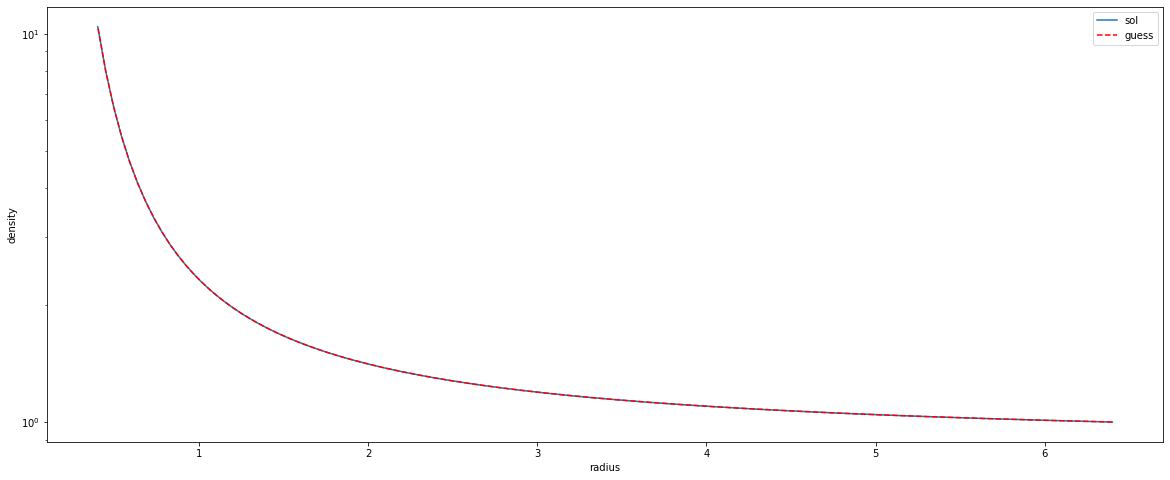

In [21]:
g = guess(r)
g = np.append(g,guess(r))
g = np.append(g,np.zeros(1))

sol = sci.optimize.root(self_grav,g, method='lm',tol=1e-12, options={"ftol":1e-12,"xtol":1e-12})

sol_d = sol.x[0*nx:1*nx]
sol_m = sol.x[1*nx:2*nx]

eq_rho = np.exp(sol.x[:nx])
mass_gas = sol.x[nx:2*nx]
rho_guess = np.exp(g[:nx])

plt.figure(figsize=(20,8))
plt.plot(r/r_B,eq_rho/rho_0)
plt.plot(r/r_B,rho_guess/rho_0,'r--')
plt.xlabel('radius')
plt.ylabel('density')
plt.legend(['sol','guess'])
plt.yscale('log')
plt.show()

# Example 3. Kelvin-Helmholtz
Here, we will create our own 2D simulation for the [Kevin-Helmholtz](https://en.wikipedia.org/wiki/Kelvin%E2%80%93Helmholtz_instability) instability! 

The two-dimensional hydro equations for this flow can be written as follows:
$$\frac{\partial}{\partial t} \begin{pmatrix}\rho \\\ \rho v_x \\\ \rho v_y \\\ \rho e\end{pmatrix} + \frac{\partial}{\partial x} \begin{pmatrix}\rho v_x \\\ \rho v_x^2 + P \\\ \rho v_xv_y \\\ (\rho e+P)v_x\end{pmatrix} + \frac{\partial}{\partial y} \begin{pmatrix}\rho v_y \\\ \rho v_yv_x + P \\\ \rho v_y^2 \\\ (\rho e+P)v_y\end{pmatrix} = \textbf{0}$$

Rewriting it in a matrix form:
$$\frac{\partial}{\partial t}\textbf{U}+\nabla\cdot\textbf{F(U)} = \textbf{0}$$
For the equation above,using divergence theorem, we can integrate it for cell $C_i$:
$$\frac{\partial}{\partial t}\int_{C_i}\textbf{U}dxdy = -\oint_{\partial C_i}\textbf{F}\cdot d\textbf{S}$$

The cell-averaged value would be ($C_i$ is the area of the cell): 
$$\textbf{U}_i(t) = \frac{1}{\vert C_i \vert} \int_{C_i}\textbf{U}(x,y,t)dxdy$$

Just like before, we will write everything in the the discritized form -- this is the equation the simulation will solve:
$$\vert C_i\vert\frac{U_i^{n+1}-U_i^n}{\Delta t}=-\sum F_i\Delta S_i$$

One of the important things to note here before we move further is the [CFL condition](https://www.simscale.com/blog/cfl-condition/#:~:text=Therefore%2C%20the%20CFL%20condition%20expresses,only%20to%20its%20immediate%20neighbors.) (or just a Courant number condition): the distance that any information travels during the timestep length within the mesh must be lower than the distance between mesh elements. We'll express it this way:
$$\Delta t = C\cdot min(\frac{\Delta x}{c_s+\vert v\vert})$$
Second-order extrapolation in space:
$$f_{i+\frac{1}{2},j} = f_{i,j}+\frac{\partial f_{i,j}}{\partial x}\frac{\Delta x}{2}$$
$$f_{i-\frac{1}{2},j} = f_{i,j}-\frac{\partial f_{i,j}}{\partial x}\frac{\Delta x}{2}$$

In [22]:
def getConserved( rho, vx, vy, P, gamma, vol ):
	"""Calculate the conserved variable from the primitive"""
	mass   = rho * vol
	momx   = rho * vx * vol
	momy   = rho * vy * vol
	energy = (P/(gamma-1) + 0.5*rho*(vx**2+vy**2))*vol
	
	return mass, momx, momy, energy


def getPrimitive(mass, momx, momy, energy, gamma, vol):
	"""Calculate the primitive variable from the conservative"""
	rho = mass / vol
	vx  = momx / rho / vol
	vy  = momy / rho / vol
	P   = (energy/vol - 0.5*rho * (vx**2+vy**2)) * (gamma-1)
	
	return rho, vx, vy, P


def getGradient(f, dx):
	"""Calculate the gradients of a field"""
	f_dx = (np.roll(f,-1,axis=0) - np.roll(f,1,axis=0)) / (2*dx)
	f_dy = (np.roll(f,-1,axis=1) - np.roll(f,1,axis=1)) / (2*dx)
	
	return f_dx, f_dy


def extrapolateInSpaceToFace(f, f_dx, f_dy, dx):
	"""Calculate the gradients of a field"""
	f_XL = f - f_dx * dx/2
	f_XL = np.roll(f_XL,-1,axis=0)
	f_XR = f + f_dx * dx/2
	
	f_YL = f - f_dy * dx/2
	f_YL = np.roll(f_YL,-1,axis=1)
	f_YR = f + f_dy * dx/2
	
	return f_XL, f_XR, f_YL, f_YR
	

def applyFluxes(F, flux_F_X, flux_F_Y, dx, dt):
	"""Apply fluxes to conserved variables"""
	# update solution
	F += - dt * dx * flux_F_X
	F += dt * dx * np.roll(flux_F_X,1,axis=0)
	F += - dt * dx * flux_F_Y
	F += dt * dx * np.roll(flux_F_Y,1,axis=1)
	
	return F


def getFlux(rho_L, rho_R, vx_L, vx_R, vy_L, vy_R, P_L, P_R, gamma):
	"""Calculate fluxed between 2 states"""
	
	# left and right energies
	en_L = P_L/(gamma-1)+0.5*rho_L * (vx_L**2+vy_L**2)
	en_R = P_R/(gamma-1)+0.5*rho_R * (vx_R**2+vy_R**2)

	# compute averaged states
	rho_ave = 0.5*(rho_L + rho_R)
	momx_ave = 0.5*(rho_L * vx_L + rho_R * vx_R)
	momy_ave = 0.5*(rho_L * vy_L + rho_R * vy_R)
	en_ave = 0.5*(en_L + en_R)
	
	P_ave = (gamma-1)*(en_ave-0.5*(momx_ave**2+momy_ave**2)/rho_ave)
	
	# compute fluxes
	flux_mass = momx_ave
	flux_momx = momx_ave**2/rho_ave + P_ave
	flux_momy = momx_ave * momy_ave/rho_ave
	flux_energy = (en_ave+P_ave) * momx_ave/rho_ave
	
	# find wavespeeds
	C_L = np.sqrt(gamma*P_L/rho_L) + np.abs(vx_L)
	C_R = np.sqrt(gamma*P_R/rho_R) + np.abs(vx_R)
	C = np.maximum( C_L, C_R )
	
	# add stabilizing diffusive term
	flux_mass -= C * 0.5 * (rho_L - rho_R)
	flux_momx -= C * 0.5 * (rho_L * vx_L - rho_R * vx_R)
	flux_momy -= C * 0.5 * (rho_L * vy_L - rho_R * vy_R)
	flux_energy -= C * 0.5 * ( en_L - en_R )

	return flux_mass, flux_momx, flux_momy, flux_energy

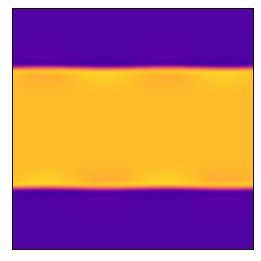

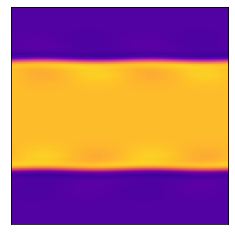

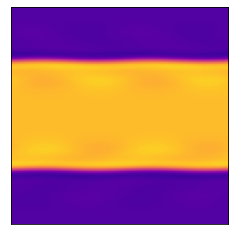

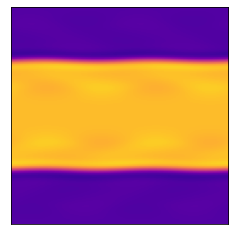

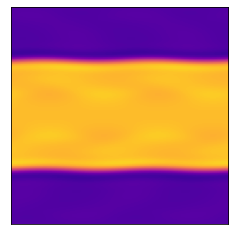

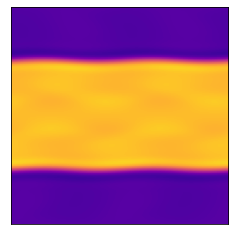

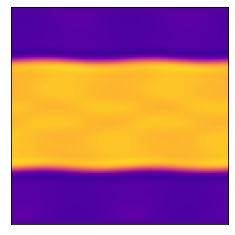

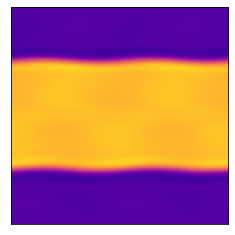

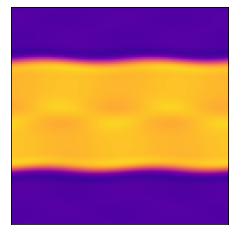

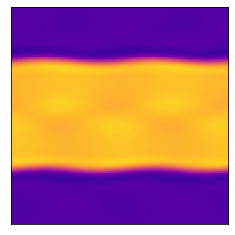

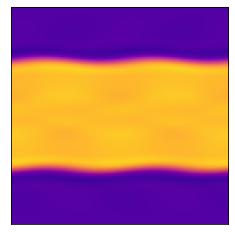

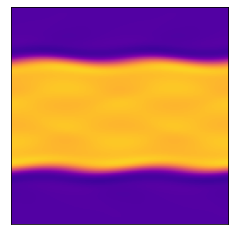

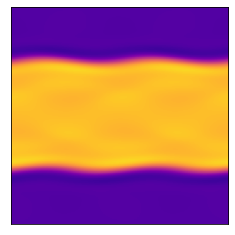

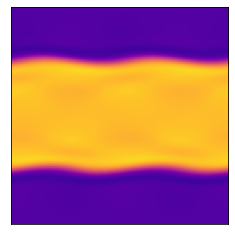

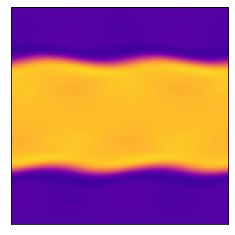

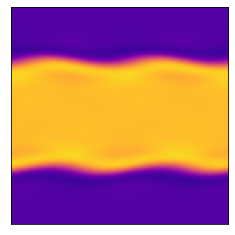

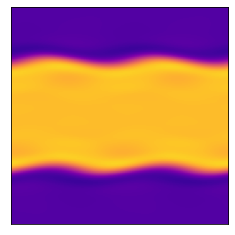

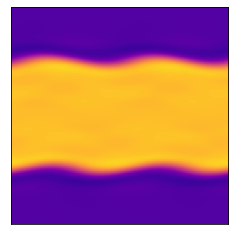

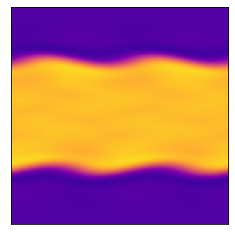

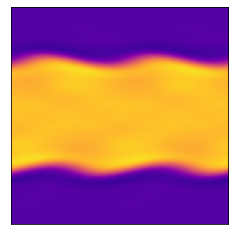

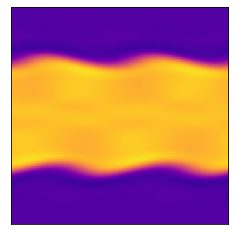

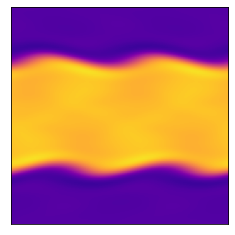

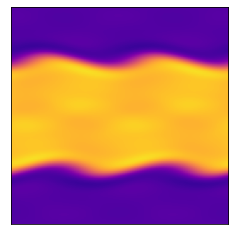

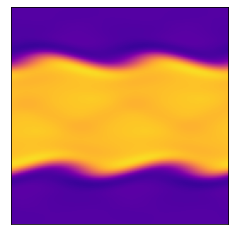

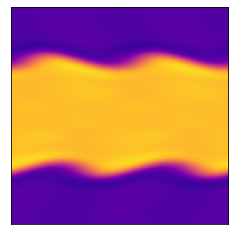

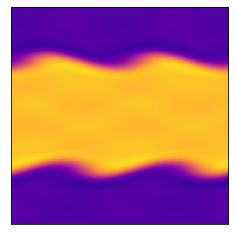

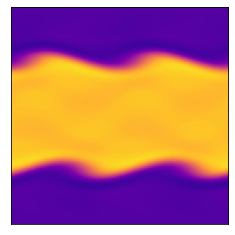

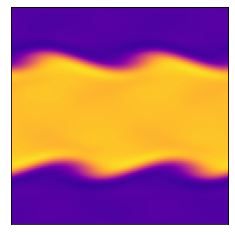

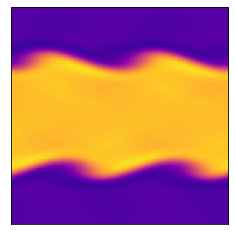

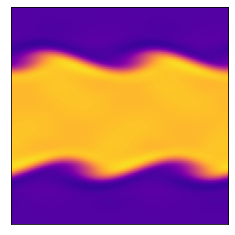

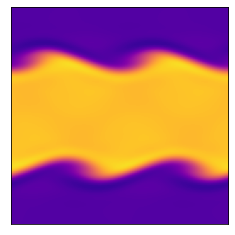

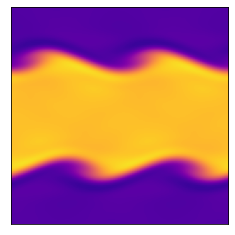

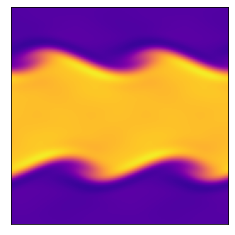

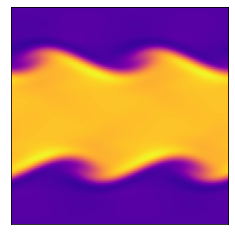

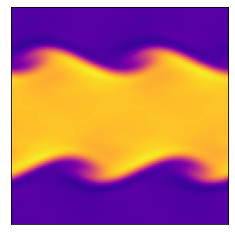

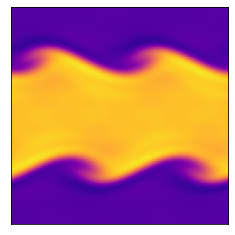

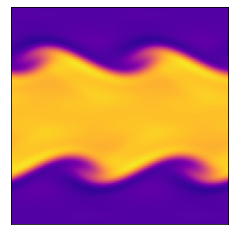

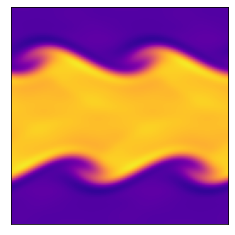

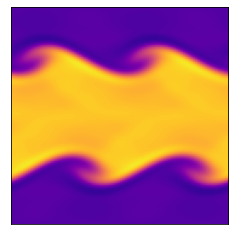

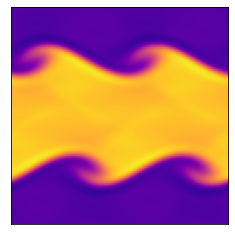

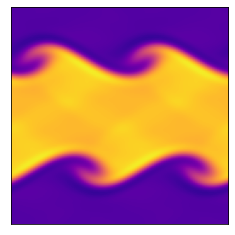

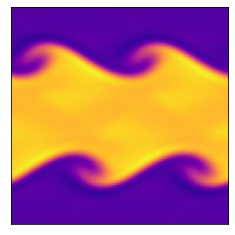

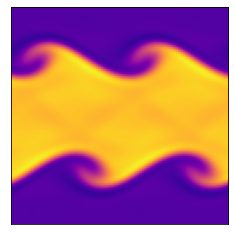

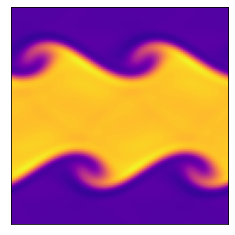

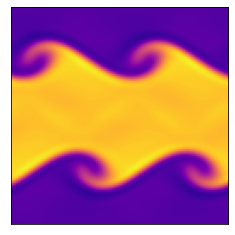

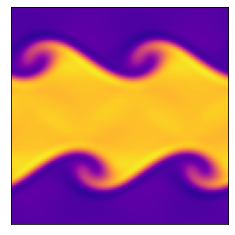

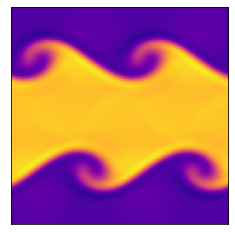

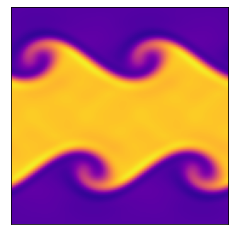

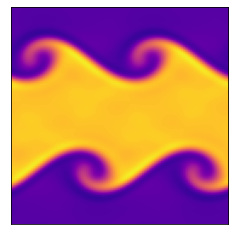

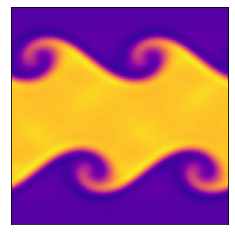

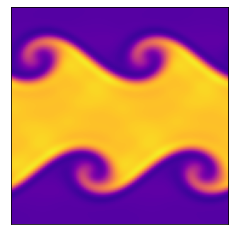

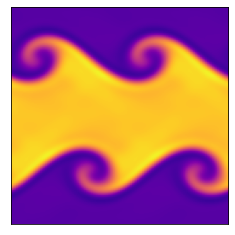

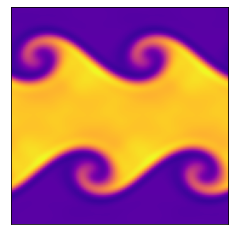

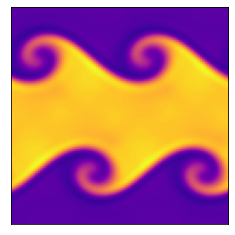

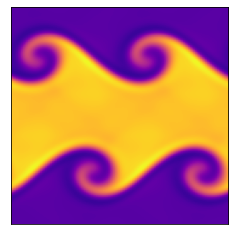

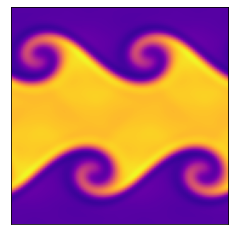

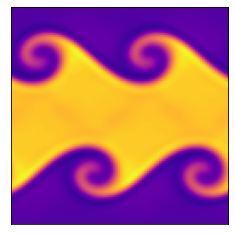

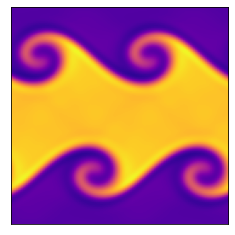

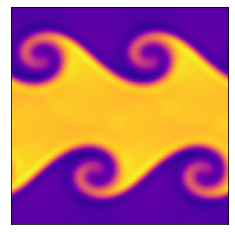

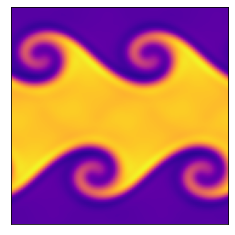

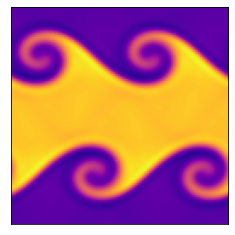

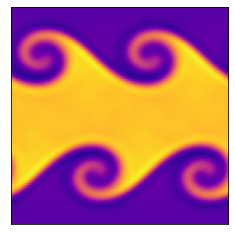

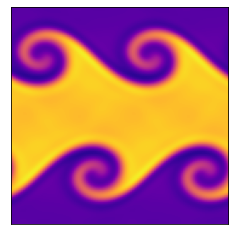

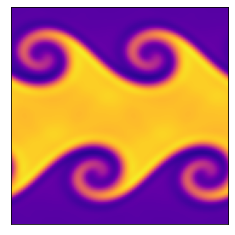

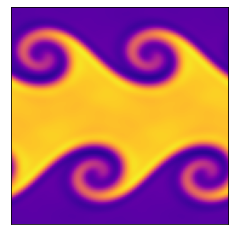

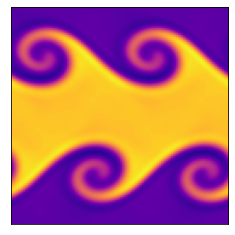

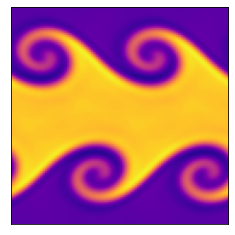

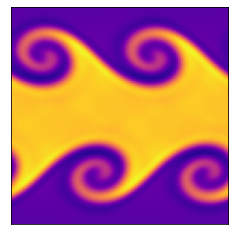

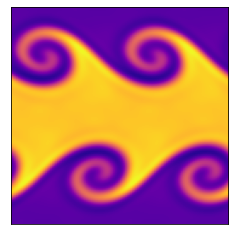

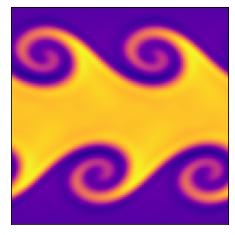

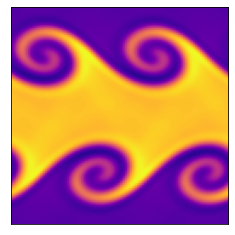

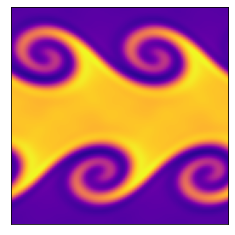

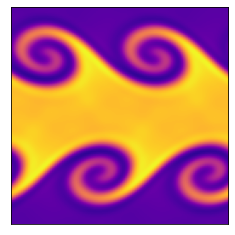

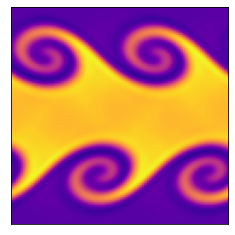

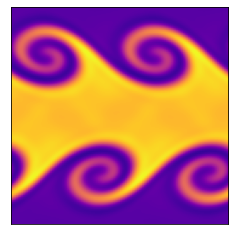

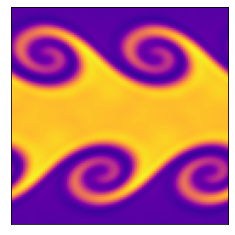

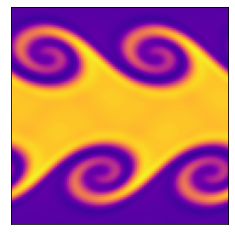

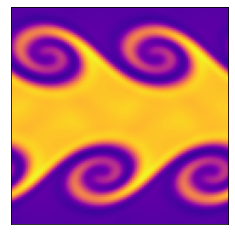

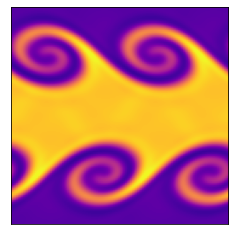

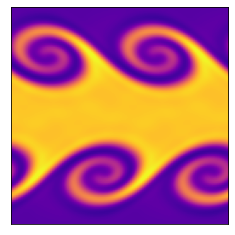

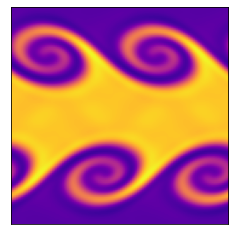

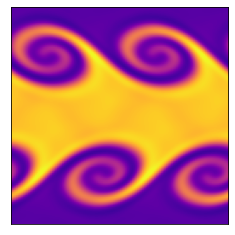

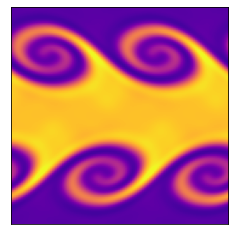

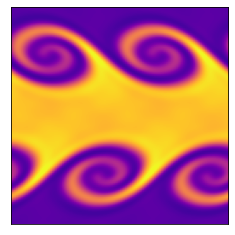

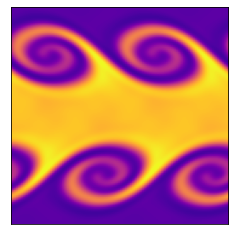

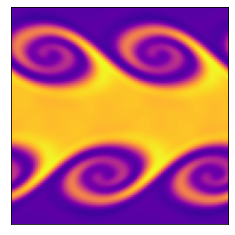

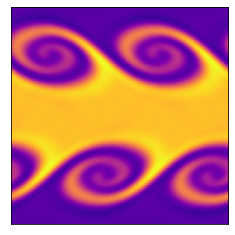

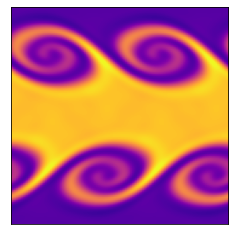

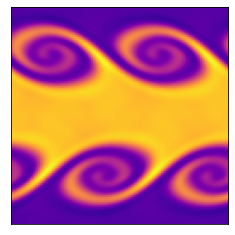

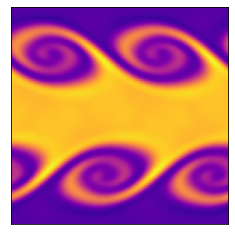

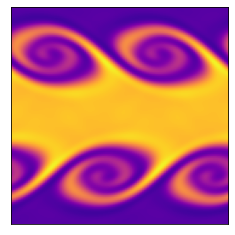

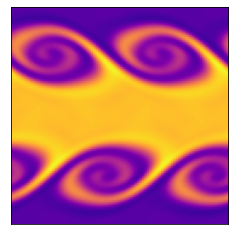

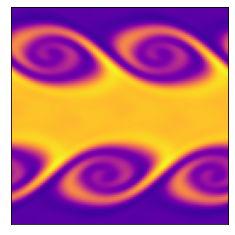

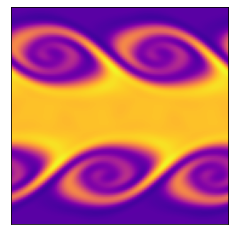

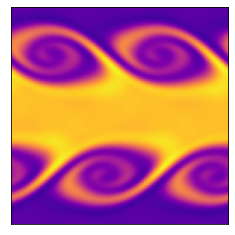

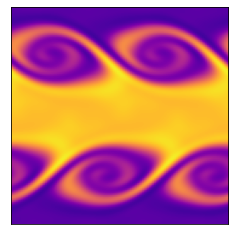

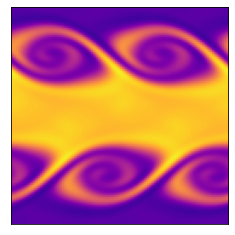

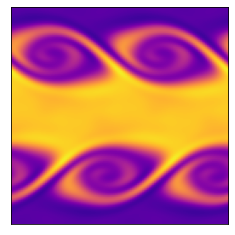

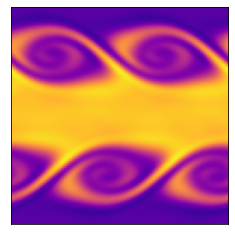

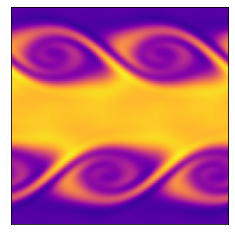

<Figure size 432x288 with 0 Axes>

In [23]:
# Simulation parameters
N = 128 # resolution
boxsize = 1.
gamma = 5/3 # ideal gas gamma
courant_fac = 0.4
t = 0
tEnd = 2
tOut = 0.02 # draw frequency
plotRealTime = True # switch on for plotting as the simulation goes along

# Mesh
dx = boxsize / N
vol = dx**2
xlin = np.linspace(0.5*dx, boxsize-0.5*dx, N)
Y, X = np.meshgrid( xlin, xlin )

# Generate Initial Conditions - opposite moving streams with perturbation
w0 = 0.1
sigma = 0.05/np.sqrt(2.)
rho = 1. + (np.abs(Y-0.5) < 0.25)
vx = -0.5 + (np.abs(Y-0.5)<0.25)
vy = w0*np.sin(4*np.pi*X) * (np.exp(-(Y-0.25)**2/(2 * sigma**2)) + np.exp(-(Y-0.75)**2/(2*sigma**2)))
P = 2.5 * np.ones(X.shape)

# Get conserved variables
mass, momx, momy, energy = getConserved(rho, vx, vy, P, gamma, vol)

# prep figure
fig = plt.figure(figsize=(4,4), dpi=80)
outputCount = 1

# Simulation Main Loop
while t < tEnd:
    
    # get Primitive variables
    rho, vx, vy, P = getPrimitive(mass, momx, momy, energy, gamma, vol)
    
    # get time step (CFL) = dx / max signal speed
    dt = courant_fac * np.min(dx / (np.sqrt( gamma*P/rho ) + np.sqrt(vx**2+vy**2)))
    plotThisTurn = False
    if t + dt > outputCount*tOut:
        dt = outputCount*tOut - t
        plotThisTurn = True
    
    # calculate gradients
    rho_dx, rho_dy = getGradient(rho, dx)
    vx_dx,  vx_dy  = getGradient(vx,  dx)
    vy_dx,  vy_dy  = getGradient(vy,  dx)
    P_dx,   P_dy   = getGradient(P,   dx)
    
    # extrapolate half-step in time
    rho_prime = rho - 0.5*dt * (vx * rho_dx + rho * vx_dx + vy * rho_dy + rho * vy_dy)
    vx_prime = vx - 0.5*dt * (vx * vx_dx + vy * vx_dy + (1/rho) * P_dx )
    vy_prime = vy - 0.5*dt * (vx * vy_dx + vy * vy_dy + (1/rho) * P_dy )
    P_prime = P - 0.5*dt * (gamma*P * (vx_dx + vy_dy)  + vx * P_dx + vy * P_dy )
    
    # extrapolate in space to face centers
    rho_XL, rho_XR, rho_YL, rho_YR = extrapolateInSpaceToFace(rho_prime, rho_dx, rho_dy, dx)
    vx_XL, vx_XR, vx_YL, vx_YR  = extrapolateInSpaceToFace(vx_prime, vx_dx, vx_dy, dx)
    vy_XL, vy_XR, vy_YL, vy_YR  = extrapolateInSpaceToFace(vy_prime, vy_dx, vy_dy, dx)
    P_XL, P_XR, P_YL, P_YR   = extrapolateInSpaceToFace(P_prime, P_dx, P_dy, dx)
    
    # compute fluxes (local Lax-Friedrichs/Rusanov)
    flux_mass_X, flux_momx_X, flux_momy_X, flux_energy_X = getFlux(rho_XL, rho_XR, vx_XL, vx_XR, vy_XL, vy_XR, P_XL, P_XR, gamma)
    flux_mass_Y, flux_momy_Y, flux_momx_Y, flux_energy_Y = getFlux(rho_YL, rho_YR, vy_YL, vy_YR, vx_YL, vx_YR, P_YL, P_YR, gamma)
    
    # update solution
    mass = applyFluxes(mass, flux_mass_X, flux_mass_Y, dx, dt)
    momx = applyFluxes(momx, flux_momx_X, flux_momx_Y, dx, dt)
    momy = applyFluxes(momy, flux_momy_X, flux_momy_Y, dx, dt)
    energy = applyFluxes(energy, flux_energy_X, flux_energy_Y, dx, dt)
    
    # update time
    t += dt
    
    # plot in real time - color 1/2 particles blue, other half red
    if (plotRealTime and plotThisTurn) or (t >= tEnd):
        plt.cla()
        plt.imshow(rho.T,cmap='plasma')
        plt.clim(0.8, 2.2)
        ax = plt.gca()
        ax.invert_yaxis()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)	
        ax.set_aspect('equal')	
        plt.pause(0.001)
        outputCount += 1
        

# Save figure
plt.savefig('finitevolume.png',dpi=240)
plt.show()

# Resources:
I personally just use only these resources:

1. Mike (slack)
2. Mike (office)
3. [Mike's textbook](http://bender.astro.sunysb.edu/hydro_by_example/CompHydroTutorial.pdf)
5. [pyro](https://github.com/python-hydro) -- code for "easy" hydro simulations 
6. *Finite Volume Methods for Hyperbolic Equations* by Leveque
7. *The Physics of Fluids and Plasmas: An Introduction for Astrophysicists* by Choudhuri